In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import math
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG = True

# Setup and preprocessing

Luckily, thanks to a preprocessed dataset and handy packages, there is almost nothing to do. The result is a sparse matrix `train_X` of dimension `n_docs` by `n_tokens`.

In [2]:
# run this once when you first get started
#! gunzip associated-press.tar.gz && tar -xvf associated-press.tar

In [2]:
train_docs = []
with open("associated-press/train.dat", 'r') as f:
    for line in f.readlines():
        train_docs.append(line)

In [3]:
vectorizer = CountVectorizer(vocabulary=None)
train_X = vectorizer.fit_transform(train_docs)
train_X = train_X.toarray() # sparse matrix is overkill for this dataset

# you may want to debug using just a fraction of the data in order to speed up the development cycle.
frac_data = 1.
n_docs, n_tokens = train_X.shape
train_X = train_X[:int(frac_data*n_docs),:]

n_docs, n_tokens = train_X.shape
n_topics = 16

# Model Building

In [4]:
def initialize_model(n_topics):    
    U = np.random.rand(n_docs, n_topics)
    U = (U.T / np.sum(U, axis=1)).T # project onto simplex
    
    V = np.ones((n_tokens,n_topics))
    V = (V.T / np.sum(V, axis=1)).T # project onto simplex
    
    Q = np.random.rand(n_topics, n_docs, n_tokens)
    Q = Q / np.sum(Q, axis=0)
    assert np.all(np.isclose(1., np.sum(Q, axis=0))) # sanity
    
    return U,V,Q

In [12]:
u,v,q = initialize_model(n_topics)

In [13]:
u.shape, v.shape

((2000, 16), (6756, 16))

# EM Inference

Here we define functions to do the E-step and the M-step as well as compute the current value of the log-likelihood as well as the lower bound $\mathcal L(X; U,V,Q) := \sum_{ij} X_{ij}\sum_{z=1}^K Q_{zij}[\log U_{iz} + \log V_{jz} - \log Q_{zij}]$, which is our actual optimization objective. Then, we run the EM algorithm for some steps.

In [5]:
def expectation_step(U, V):
    Qprime = np.einsum('ik,jk -> kij', U, V)
    normalizer = np.matmul(U, V.T).T
    
    Qprime = Qprime / (normalizer.T )
    Qprime = Qprime.reshape([n_topics, n_docs, n_tokens])
    return Qprime

In [14]:
qp = expectation_step(u, v)

In [15]:
qp.shape

(16, 2000, 6756)

In [6]:
def maximization_step(U, V, Q, X, eps=1e-2):
    assert np.all(np.isclose(np.sum(Q, axis=0), 1.)) # sanity
    
    Uprime = np.einsum('ij,kij -> ik', X, Q)
    Uprime = (Uprime.T / np.sum(X, axis=1)).T
    
    assert np.all(np.isclose(np.sum(Uprime, axis=1), 1.))
    
    Vprime = np.einsum('ij,kij -> jk', X, Q) 
    Vprime = Vprime + eps 
    Vprime = Vprime/np.sum(Vprime,axis=0)
    #/ np.einsum('ij,kij -> k', X, Q)
    
    assert np.all(np.isclose(np.sum(Vprime, axis=0), 1.))
    
    return Uprime, Vprime

In [7]:
def compute_lower_bound(U, V, Q, X):    
    part = np.einsum('kij,ik -> ij',     Q, np.log(U)) \
            + np.einsum('kij,jk -> ij',  Q, np.log(V)) \
            - np.einsum('kij,kij -> ij', Q, np.log(Q))
    part *= X
    ret = np.sum(part)
    return ret

def compute_loglikelihood(U, V, Q, X, eps=1e-4): 
    part = np.einsum('ik,jk -> ij',     U, V)
    part = np.log(part+eps)
    part *= X
    return np.sum(part)

In [8]:
U,V,Q = initialize_model(n_topics)
n_itrs = 25 # number of iterations 
lowerbounds = np.zeros(n_itrs)
loglikelihoods = np.zeros(n_itrs)
for i in range(n_itrs):
    print("EM iteration {}".format(i))
    Q = expectation_step(U, V)
    
    # check if the lower bound is maximized in the E-step.
    assert np.isclose(compute_lower_bound(U, V, Q, train_X),
                      compute_loglikelihood(U, V, Q, train_X, eps=1e-10))
    
    U, V = maximization_step(U, V, Q, train_X)
    lowerbounds[i] = compute_lower_bound(U,V,Q,train_X)
    loglikelihoods[i] = compute_loglikelihood(U,V,Q,train_X)

EM iteration 0
EM iteration 1
EM iteration 2
EM iteration 3
EM iteration 4
EM iteration 5
EM iteration 6
EM iteration 7
EM iteration 8
EM iteration 9
EM iteration 10
EM iteration 11
EM iteration 12
EM iteration 13
EM iteration 14
EM iteration 15
EM iteration 16
EM iteration 17
EM iteration 18
EM iteration 19
EM iteration 20
EM iteration 21
EM iteration 22
EM iteration 23
EM iteration 24


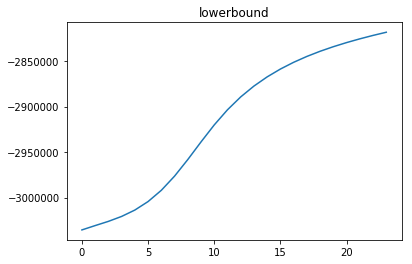

In [9]:
%matplotlib inline
import matplotlib.pyplot  as plt
plt.title('lowerbound')
plt.plot(lowerbounds[0:i])

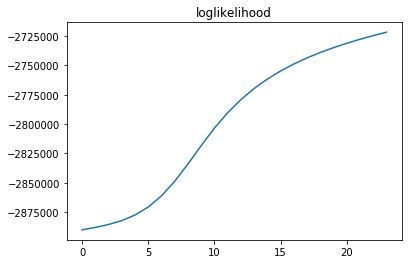

In [10]:
plt.title('loglikelihood')
plt.plot(loglikelihoods[0:i])

# Analysis 
For each topic, we print the top 5 associated words i.e. the words for which $V[w,topic]$ is maximized. 

In [11]:
n_top = 5
names = vectorizer.get_feature_names()

for t in range(n_topics): 
    print('---------')
    print('topic: ' + str(t))
    indeces = sorted(range(len(names)), key=lambda k: V[k,t],reverse=True) 
    for i in range(n_top): 
        print(names[indeces[i]])

---------
topic: 0
parti
elect
state
polit
vote
---------
topic: 1
million
compani
stock
share
billion
---------
topic: 2
peopl
govern
south
report
citi
---------
topic: 3
drug
investig
offic
say
attorney
---------
topic: 4
unit
state
foreign
iraq
offici
---------
topic: 5
soviet
gorbachev
union
year
offici
---------
topic: 6
cent
oil
year
price
percent
---------
topic: 7
polic
peopl
kill
two
offici
---------
topic: 8
school
student
children
year
hospit
---------
topic: 9
west
east
israel
german
report
---------
topic: 10
bush
presid
dukaki
democrat
hou
---------
topic: 11
percent
year
tax
billion
congress
---------
topic: 12
plant
worker
compani
depart
contract
---------
topic: 13
percent
rate
trade
dollar
market
---------
topic: 14
year
new
first
like
reagan
---------
topic: 15
court
case
rule
pilot
judg
